In [2]:
from pyspark import SparkConf
from pyspark.sql import SparkSession
from datetime import datetime
from pyspark.sql.functions import broadcast
# startTime = datetime.now()

In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy 
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
import matplotlib.mlab as mlab
%matplotlib inline




Bad key "backend.qt4" on line 43 in
/etc/matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.2.2/matplotlibrc.template
or from the matplotlib source distribution


In [4]:
import pandas as pd
from pandas import DataFrame
import numpy as np 
import scipy 
import scipy.stats as ss
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

In [5]:
conf = SparkConf()

conf = conf.set("spark.executor.instances", '8')
conf = conf.set("spark.executor.cores", '4')
conf = conf.set("spark.executor.memory", "60G")
# conf = conf.set("spark.jars", "db2jcc4.jar")
conf = conf.set("spark.sql.legacy.allowCreatingManagedTableUsingNonemptyLocation","true")
conf = conf.set("spark.sql.broadcastTimeout",  "900")
conf = conf.set("spark.driver.maxResultSize", "8g")

spark = SparkSession.builder \
    .config(conf=conf) \
    .config('spark.dynamicAllocation.enabled', 'false') \
    .config('spark.kryoserializer.buffer.max', '2047') \
    .config('spark.io.compression.codec', 'snappy') \
    .config('spark.blacklist.enabled', 'false') \
    .config('spark.dynamicAllocation.enabled', 'false') \
    .master("yarn") \
    .appName("---") \
    .config('spark.yarn.executor.memoryOverhead', '10g') \
    .enableHiveSupport() \
    .getOrCreate()

# PREPROCESSING DATA

In [15]:
# INPUT DATA
df=spark.sql("""


select *  
from dev_staging.dm_profilling_te_channel_detail

""")

# type(df)

In [16]:
type(df)

pyspark.sql.dataframe.DataFrame

In [17]:
df.show()

+---------------+----+---------+----------------+---------+----------+-------------------+-----------+---------------+----------+----------+----+-----+-------+----------+----------+------------+-----------+--------------+-----+-------+-----------------+----------+----------+-------------+----------+-----------------+---------+----------+-----------+-----------+
|status_customer| cif|create_by|           norek|CLIENT_ID|CHANNEL_ID|           tgl_buka|TARGET_CUST|total_transaksi|status_kyc|source_kyc|nama|no_id|user_id|branch_kyc|status_rek|total_amount|total_berat|       channel|agama|profesi|jumlah_tanggungan|pendidikan|range_gaji|jenis_kelamin|range_usia|dukcapil_verified|region_nm|segmentasi|rekomendasi|churn_proba|
+---------------+----+---------+----------------+---------+----------+-------------------+-----------+---------------+----------+----------+----+-----+-------+----------+----------+------------+-----------+--------------+-----+-------+-----------------+----------+--------

In [18]:
import databricks.koalas as ks

In [19]:
kdf= df.to_koalas()
kdf.shape

(2383461, 31)

In [20]:
isna_rep = kdf.isna().sum().to_frame().reset_index()
isna_rep.columns = ['var','sum_na']
isna_rep['%']=isna_rep['sum_na']/len(kdf)*100
isna_rep

,var,sum_na,%
0,status_customer,0,0.000000
1,cif,1652758,69.342775
2,create_by,1652758,69.342775
3,norek,0,0.000000
4,CLIENT_ID,0,0.000000
5,CHANNEL_ID,0,0.000000
6,tgl_buka,217,0.009104
7,TARGET_CUST,286,0.011999
8,total_transaksi,0,0.000000
9,status_kyc,1677567,70.383656


In [21]:
kdf.info()

databricks.koalas.frame.DataFrame
Index: 2383461 entries, 0 to 2383460
Data columns (total 31 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   status_customer    2383461 non-null  object        
 1   cif                730703 non-null   object        
 2   create_by          730703 non-null   object        
 3   norek              2383461 non-null  object        
 4   CLIENT_ID          2383461 non-null  object        
 5   CHANNEL_ID         2383461 non-null  object        
 6   tgl_buka           2383244 non-null  datetime64[ns]
 7   TARGET_CUST        2383175 non-null  int32         
 8   total_transaksi    2383461 non-null  int64         
 9   status_kyc         705894 non-null   object        
 10  source_kyc         222983 non-null   object        
 11  nama               711013 non-null   object        
 12  no_id              711013 non-null   object        
 13  user_id            115526 non-null  

In [22]:
kdf.describe()

,TARGET_CUST,total_transaksi,total_amount,total_berat,jumlah_tanggungan,churn_proba
count,2.383175e+06,2.383461e+06,7.146050e+05,714605.000000,3332.000000,83055.000000
mean,4.049020e+05,1.554984e+01,1.036044e+06,1.597544,1.867300,0.650725
std,7.696148e+04,6.127804e+02,4.783508e+07,64.431256,1.354731,0.105145
min,5.000000e+03,1.000000e+00,0.000000e+00,0.000100,1.000000,0.500000
25%,2.800000e+05,1.000000e+00,5.027000e+03,0.005700,1.000000,0.584100
50%,4.500000e+05,2.000000e+00,1.614550e+04,0.025100,2.000000,0.618000
75%,4.500000e+05,6.000000e+00,1.229382e+05,0.170600,2.000000,0.709100
max,4.500000e+05,3.211580e+05,3.857528e+10,52605.027400,35.000000,0.966200


In [23]:
kdf.segmentasi.value_counts() 

Uncertain       217658
FirstTime       211884
Shopper         151540
Frequent         46126
Best             13854
AboutToSleep      1938
Valuable           829
Spenders           504
Name: segmentasi, dtype: int64

In [24]:
# delet jumlah tanggungan
kdf = kdf.drop(columns="jumlah_tanggungan")


In [25]:
kdf.shape

(2383461, 30)

In [16]:
# drop na
# kdf = kdf.dropna()
# kdf.shape

In [26]:
kdf.info()

databricks.koalas.frame.DataFrame
Index: 2383461 entries, 0 to 2383460
Data columns (total 30 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   status_customer    2383461 non-null  object        
 1   cif                730703 non-null   object        
 2   create_by          730703 non-null   object        
 3   norek              2383461 non-null  object        
 4   CLIENT_ID          2383461 non-null  object        
 5   CHANNEL_ID         2383461 non-null  object        
 6   tgl_buka           2383244 non-null  datetime64[ns]
 7   TARGET_CUST        2383175 non-null  int32         
 8   total_transaksi    2383461 non-null  int64         
 9   status_kyc         705894 non-null   object        
 10  source_kyc         222983 non-null   object        
 11  nama               711013 non-null   object        
 12  no_id              711013 non-null   object        
 13  user_id            115526 non-null  

In [27]:
pdf=kdf.to_pandas()

In [28]:
type(pdf)

pandas.core.frame.DataFrame

In [29]:
pd.qcut(pdf['total_amount'],5, duplicates = 'drop').value_counts()

(3062.4, 10050.3]             143219
(-0.001, 3062.4]              142966
(197105.66, 38575280959.2]    142921
(32820.76, 197105.66]         142921
(10050.3, 32820.76]           142578
Name: total_amount, dtype: int64

In [30]:
pdf['total_amount']=pd.qcut(pdf['total_amount'],5, duplicates = 'drop')

In [31]:
pdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2383461 entries, 0 to 2383460
Data columns (total 30 columns):
 #   Column             Dtype         
---  ------             -----         
 0   status_customer    object        
 1   cif                object        
 2   create_by          object        
 3   norek              object        
 4   CLIENT_ID          object        
 5   CHANNEL_ID         object        
 6   tgl_buka           datetime64[ns]
 7   TARGET_CUST        float64       
 8   total_transaksi    int64         
 9   status_kyc         object        
 10  source_kyc         object        
 11  nama               object        
 12  no_id              object        
 13  user_id            object        
 14  branch_kyc         object        
 15  status_rek         object        
 16  total_amount       category      
 17  total_berat        float64       
 18  channel            object        
 19  agama              object        
 20  profesi            objec

In [61]:
x1=pdf[['agama',
'segmentasi',
'rekomendasi',
'channel',
'range_usia',
'jenis_kelamin',
'total_amount',
'status_rek',
'profesi',
'pendidikan',
'range_gaji',
'region_nm',
'status_kyc','total_transaksi']]

In [62]:
x2=x1.dropna()

In [63]:
x2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107716 entries, 1672450 to 2383459
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   agama            107716 non-null  object  
 1   segmentasi       107716 non-null  object  
 2   rekomendasi      107716 non-null  object  
 3   channel          107716 non-null  object  
 4   range_usia       107716 non-null  object  
 5   jenis_kelamin    107716 non-null  object  
 6   total_amount     107716 non-null  category
 7   status_rek       107716 non-null  object  
 8   profesi          107716 non-null  object  
 9   pendidikan       107716 non-null  object  
 10  range_gaji       107716 non-null  object  
 11  region_nm        107716 non-null  object  
 12  status_kyc       107716 non-null  object  
 13  total_transaksi  107716 non-null  int64   
dtypes: category(1), int64(1), object(12)
memory usage: 11.6+ MB


In [64]:
#make label
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

segmentasi_encoded = le.fit_transform(x2['segmentasi'])
x2['segmentasi_encoded'] = segmentasi_encoded

agama_encoded = le.fit_transform(x2['agama'])
x2['agama_encoded'] = agama_encoded

rekomendasi_encoded = le.fit_transform(x2['rekomendasi'])
x2['rekomendasi_encoded'] = rekomendasi_encoded

channel_encoded = le.fit_transform(x2['channel'])
x2['channel_encoded'] = channel_encoded

range_usia_encoded = le.fit_transform(x2['range_usia'])
x2['range_usia_encoded'] = range_usia_encoded

jenis_kelamin_encoded = le.fit_transform(x2['jenis_kelamin'])
x2['jenis_kelamin_encoded'] = jenis_kelamin_encoded

total_amount_encoded = le.fit_transform(x2['total_amount'])
x2['total_amount_encoded'] = total_amount_encoded

status_rek_encoded = le.fit_transform(x2['status_rek'])
x2['status_rek_encoded'] = status_rek_encoded

profesi_encoded = le.fit_transform(x2['profesi'])
x2['profesi_encoded'] = profesi_encoded


pendidikan_encoded = le.fit_transform(x2['pendidikan'])
x2['pendidikan_encoded'] = pendidikan_encoded

range_gaji_encoded = le.fit_transform(x2['range_gaji'])
x2['range_gaji_encoded'] = range_gaji_encoded

region_nm_encoded = le.fit_transform(x2['region_nm'])
x2['region_nm_encoded'] = region_nm_encoded

status_kyc_encoded = le.fit_transform(x2['status_kyc'])
x2['status_kyc_encoded'] = status_kyc_encoded




print(x2)
# pdf_label = le.fit_transform(pdf[['jenis_kelamin']])
# pdf.head_label(100)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

           agama    segmentasi             rekomendasi channel range_usia  \
1672450    ISLAM     Uncertain               Not_Churn  SHOPEE      35-45   
1672460    ISLAM       Shopper               Not_Churn  SHOPEE      25-35   
1672463    ISLAM     Uncertain               Not_Churn  SHOPEE      45-55   
1672464    ISLAM     Uncertain               Not_Churn  SHOPEE      25-35   
1672465  KRISTEN     Uncertain               Not_Churn  SHOPEE      25-35   
...          ...           ...                     ...     ...        ...   
2383448  KRISTEN     Uncertain    Low Cost Maintenance  SHOPEE      45-55   
2383449  KATOLIK     Uncertain               Not_Churn  SHOPEE      25-35   
2383455    ISLAM  AboutToSleep  Sustained Relationship  SHOPEE      35-45   
2383457    ISLAM     FirstTime               Not_Churn  SHOPEE      25-35   
2383459    ISLAM     FirstTime               Not_Churn  SHOPEE      16-25   

        jenis_kelamin                total_amount status_rek  \
1672450    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [65]:
x2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107716 entries, 1672450 to 2383459
Data columns (total 27 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   agama                  107716 non-null  object  
 1   segmentasi             107716 non-null  object  
 2   rekomendasi            107716 non-null  object  
 3   channel                107716 non-null  object  
 4   range_usia             107716 non-null  object  
 5   jenis_kelamin          107716 non-null  object  
 6   total_amount           107716 non-null  category
 7   status_rek             107716 non-null  object  
 8   profesi                107716 non-null  object  
 9   pendidikan             107716 non-null  object  
 10  range_gaji             107716 non-null  object  
 11  region_nm              107716 non-null  object  
 12  status_kyc             107716 non-null  object  
 13  total_transaksi        107716 non-null  int64   
 14  segmentasi_en

In [66]:
x3=x2[['segmentasi_encoded',
'agama_encoded',
'rekomendasi_encoded',
'channel_encoded',
'range_usia_encoded',
'jenis_kelamin_encoded',
'total_amount_encoded',
'status_rek_encoded',
'profesi_encoded',
'pendidikan_encoded',
'range_gaji_encoded',
'region_nm_encoded',
'status_kyc_encoded',
'total_transaksi']]

In [67]:
x3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107716 entries, 1672450 to 2383459
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype
---  ------                 --------------   -----
 0   segmentasi_encoded     107716 non-null  int64
 1   agama_encoded          107716 non-null  int64
 2   rekomendasi_encoded    107716 non-null  int64
 3   channel_encoded        107716 non-null  int64
 4   range_usia_encoded     107716 non-null  int64
 5   jenis_kelamin_encoded  107716 non-null  int64
 6   total_amount_encoded   107716 non-null  int64
 7   status_rek_encoded     107716 non-null  int64
 8   profesi_encoded        107716 non-null  int64
 9   pendidikan_encoded     107716 non-null  int64
 10  range_gaji_encoded     107716 non-null  int64
 11  region_nm_encoded      107716 non-null  int64
 12  status_kyc_encoded     107716 non-null  int64
 13  total_transaksi        107716 non-null  int64
dtypes: int64(14)
memory usage: 12.3 MB


In [68]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = scipy.stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [69]:
a=[]
index=[]
for i in range(0,len(x3.columns)):
  b=[]
  for j in range(0,len(x3.columns)):
    c = cramers_v (x3[x3.columns[i]],x3[x3.columns[j]])
    b.append(c)
  a.append(b)
  index.append(x3.columns[i])

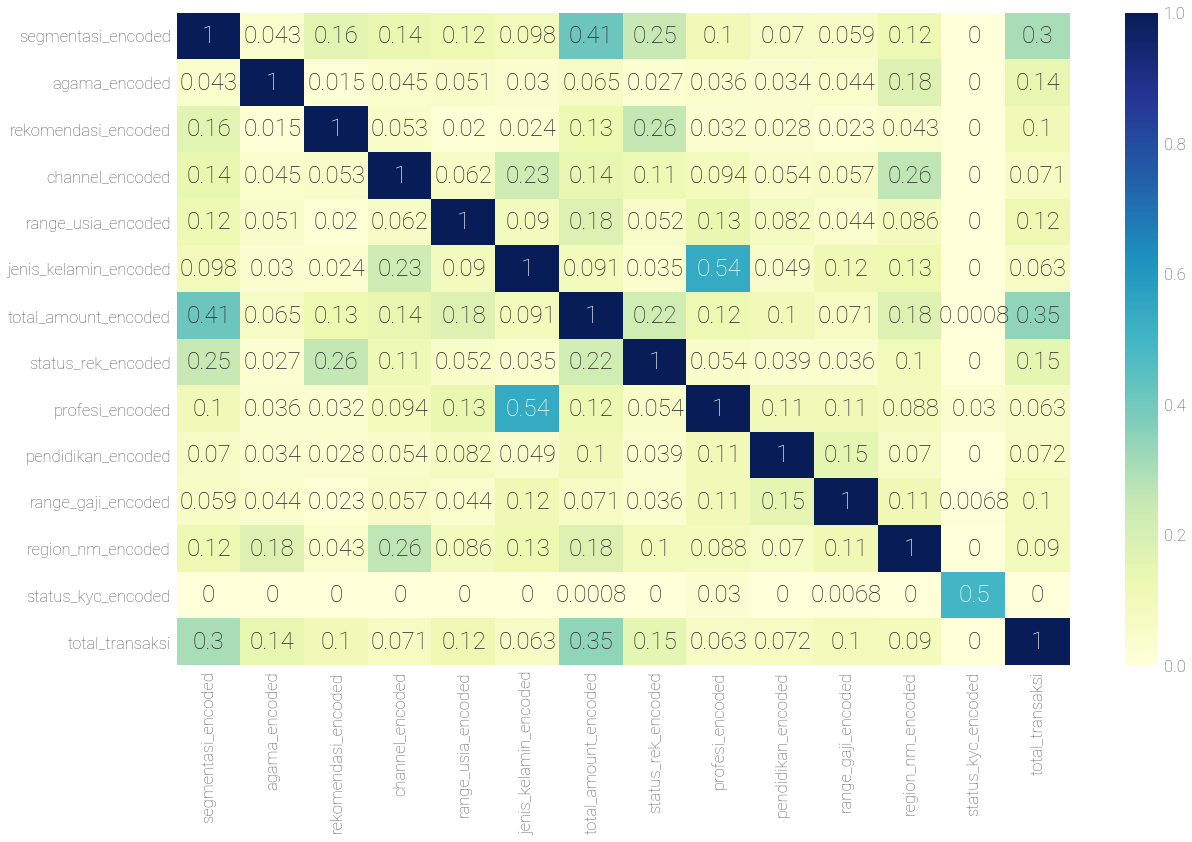

In [70]:
df2 = DataFrame(np.array(a), index=index, columns=index)

plt.figure(figsize = (20,12))
heatmap1=sns.heatmap(df2, annot=True, cmap="YlGnBu")
plt.rcParams.update({'font.size': 24})
plt.show()

In [71]:
heatmap1.figure.savefig('CremerV.png')

In [98]:
df2

,segmentasi_encoded,agama_encoded,rekomendasi_encoded,channel_encoded,range_usia_encoded,jenis_kelamin_encoded
segmentasi_encoded,1.000000,0.039623,0.166276,0.166432,0.075843,0.087883
agama_encoded,0.039623,1.000000,0.005994,0.049491,0.041012,0.016486
rekomendasi_encoded,0.166276,0.005994,1.000000,0.066660,0.017145,0.061732
channel_encoded,0.166432,0.049491,0.066660,1.000000,0.077191,0.258203
range_usia_encoded,0.075843,0.041012,0.017145,0.077191,1.000000,0.121466
jenis_kelamin_encoded,0.087883,0.016486,0.061732,0.258203,0.121466,0.999996
